In [ ]:
from sklearn.impute import SimpleImputer

#from base1 import *
from base2 import *

X_train_1 = pd.read_csv('csv/X_train_eu.csv', index_col='Unnamed: 0')
y_train = pd.read_csv('csv/y_train_eu.csv', index_col='Unnamed: 0')
X_val_1 = pd.read_csv('csv/X_val_eu.csv', index_col='Unnamed: 0')
y_val = pd.read_csv('csv/y_val_eu.csv', index_col='Unnamed: 0')
X_test_1 = pd.read_csv('csv/X_test_eu.csv', index_col='Unnamed: 0')
y_test = pd.read_csv('csv/y_test_eu.csv', index_col='Unnamed: 0')

y_train = (y_train['auop']).astype(str)
y_val = (y_val['auop']).astype(str)
y_test = (y_test['auop']).astype(str)

y_train = y_train.replace({'1': 1, '4': 0})
y_val = y_val.replace({'1': 1, '4': 0})
y_test = y_test.replace({'1': 1, '4': 0})

X_train = X_train_1
X_val = X_val_1
X_test = X_test_1 

col_names = X_train.columns.to_list()
col_names.remove("X23")
col_names.remove("X140")

runned!
['PCA', 'SMOTE', 'SimpleImputer', 'StandardScaler', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_pca_table', 'np', 'pca_on_train_and_transform_full_data', 'pd', 'plt', 'preprocess_and_apply_smote1', 'remove_outliers_iqr', 'scale_columns1', 'scale_columns2']


<ipython-input-1-b3bd3971a989>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace({'1': 1, '4': 0})
<ipython-input-1-b3bd3971a989>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = y_val.replace({'1': 1, '4': 0})
<ipython-input-1-b3bd3971a989>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

In [ ]:
# Calculate frequency encoding on the training set
frequency_encoding = X_train['X140'].value_counts(normalize=True)
# Map the frequencies to the sector column in each dataset
X_train['X141'] = X_train['X140'].map(frequency_encoding)
X_val['X141'] = X_val['X140'].map(frequency_encoding)
X_test['X141'] = X_test['X140'].map(frequency_encoding)
# Fill any missing values that might arise if a category in val/test wasn't in train
X_val['X141'].fillna(0, inplace=True)
X_test['X141'].fillna(0, inplace=True)

<ipython-input-2-74f27a44d357>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val['X141'].fillna(0, inplace=True)
<ipython-input-2-74f27a44d357>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method(

In [ ]:
# Drop column 'X140' from each DataFrame
X_train = X_train.drop(columns=['X140'])
X_val = X_val.drop(columns=['X140'])
X_test = X_test.drop(columns=['X140'])

# Deal with missing values in the features 
missing_threshold = 0.8
missing_train = X_train.isnull().mean()
cols_to_drop = missing_train[missing_train > missing_threshold].index
# Drop the identified columns from both the training and test sets
X_train = X_train.drop(cols_to_drop, axis=1)
X_val = X_val.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)
print(f"Columns dropped: {list(cols_to_drop)}")

col_names = X_train.columns.to_list()
col_names.remove("X23")

Columns dropped: ['X20', 'X119']


In [ ]:
# remove outliers
X_train, y_train, removed_counts = k.remove_outliers_iqr(X_train, y_train, col_names, min_outliers= 20)
print("Rows removed per class:", removed_counts)

# Deal with missing values
max_missing = 17
X_train = X_train[X_train.isnull().sum(axis=1) < max_missing]
y_train = y_train.loc[X_train.index]

Rows removed per class: {1: 1716, 0: 665}


In [ ]:
# Replace 'inf' and '-inf' with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
# Initialize SimpleImputer with the 'mean' strategy
imputer = SimpleImputer(strategy='mean')
# Fit the imputer on the training data and transform it
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# Apply the same imputer to the validation and test sets (without refitting)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [ ]:
# Use SMOTE to oversample the minority class in the training set
smote = SMOTE()
X_train_resampled, y_train = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", pd.Series(y_train.value_counts()))

Class distribution after SMOTE: auop
1    5823
0    5823
Name: count, dtype: int64


Data has been split, outliers removed, and data scaled.


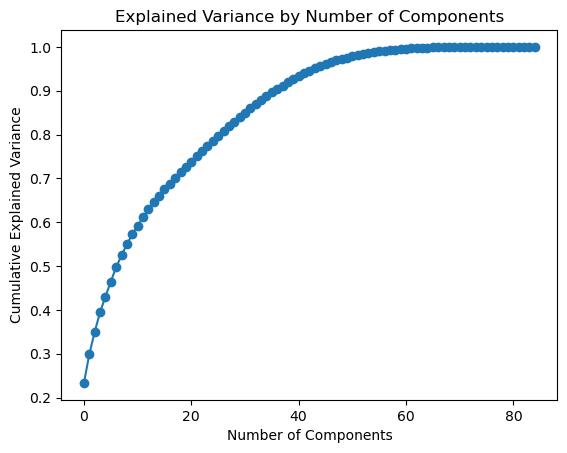

   Principal Component  Eigenvalue  Explained Variance  \
0                 PC_1   19.602200            0.233339   
1                 PC_2    5.508360            0.065570   
2                 PC_3    4.282629            0.050979   
3                 PC_4    3.747072            0.044604   
4                 PC_5    3.016331            0.035906   
5                 PC_6    2.857759            0.034018   
6                 PC_7    2.778574            0.033075   
7                 PC_8    2.250693            0.026792   
8                 PC_9    2.138429            0.025455   
9                PC_10    1.889213            0.022489   
10               PC_11    1.659384            0.019753   
11               PC_12    1.606276            0.019121   
12               PC_13    1.544585            0.018386   
13               PC_14    1.372131            0.016333   
14               PC_15    1.247579            0.014851   
15               PC_16    1.186180            0.014120   
16            

In [ ]:
# Scale the data
X_train, X_val, X_test = k.scale_columns1(X_train_resampled, X_val, X_test, col_names)
print("Data has been split, outliers removed, and data scaled.")

X_train_full, X_val_full, X_test_full, explained_variance, eigenvalues = k.pca_on_train_and_transform_full_data(X_train, X_val, X_test)

pca_table = k.create_pca_table(explained_variance, eigenvalues)
print(pca_table)

In [ ]:
# Select columns
X_train_svm = X_train_full.iloc[:, :len(pca_table)]
X_val_svm = X_val_full.iloc[:, :len(pca_table)]
X_test_svm = X_test_full.iloc[:, :len(pca_table)]

In [ ]:
# Create an SVM classifier with RBF kernel (Saeedi, 2021)
svm_rbf = SVC(kernel='rbf')
# Perform 10-fold cross-validation on the training data
cv_scores = cross_val_score(svm_rbf, X_train_svm, y_train, cv=10)
# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
# Train the SVM model on the full training set
svm_rbf.fit(X_train_svm, y_train)
# Evaluate on the validation set
y_val_pred = svm_rbf.predict(X_val_svm)
print("Validation set classification report:")
print(classification_report(y_val, y_val_pred))
# Optionally, you can evaluate on the test set as well
y_test_pred = svm_rbf.predict(X_test_svm)
print("Test set classification report:")
print(classification_report(y_test, y_test_pred))

Cross-validation scores: [0.70128755 0.7167382  0.69613734 0.72961373 0.74849785 0.71587983
 0.70704467 0.70532646 0.7104811  0.70704467]
Mean cross-validation score: 0.7138051413654264
Validation set classification report:
              precision    recall  f1-score   support

           0       0.32      0.49      0.39      1115
           1       0.81      0.68      0.74      3548

    accuracy                           0.63      4663
   macro avg       0.56      0.58      0.56      4663
weighted avg       0.69      0.63      0.65      4663

Test set classification report:
              precision    recall  f1-score   support

           0       0.40      0.58      0.47      1267
           1       0.81      0.68      0.74      3401

    accuracy                           0.65      4668
   macro avg       0.61      0.63      0.61      4668
weighted avg       0.70      0.65      0.67      4668



In [ ]:
from joblib import dump, load
# Save the trained SVM model
dump(svm_rbf, "eu_svm_rbf_1118.joblib")

# Load the saved SVM model
svm_rbf_loaded = load("eu_svm_rbf_1118.joblib")
# Verify by running predictions
y_test_pred_loaded = svm_rbf_loaded.predict(X_test_svm)
print(classification_report(y_test, y_test_pred_loaded))

              precision    recall  f1-score   support

           0       0.40      0.58      0.47      1267
           1       0.81      0.68      0.74      3401

    accuracy                           0.65      4668
   macro avg       0.61      0.63      0.61      4668
weighted avg       0.70      0.65      0.67      4668



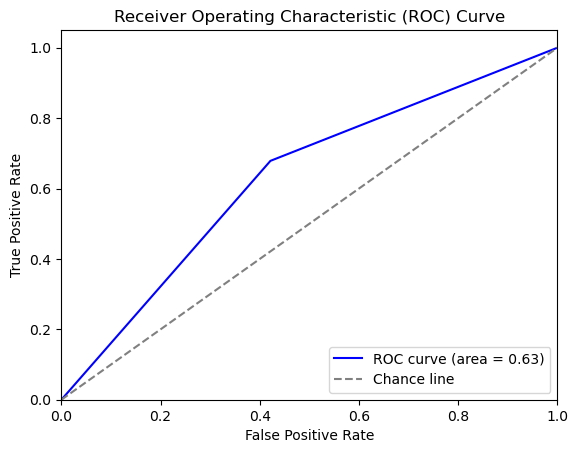

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = y_test
y_pred_proba = y_test_pred 
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("results/241118 EU/SVM_roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

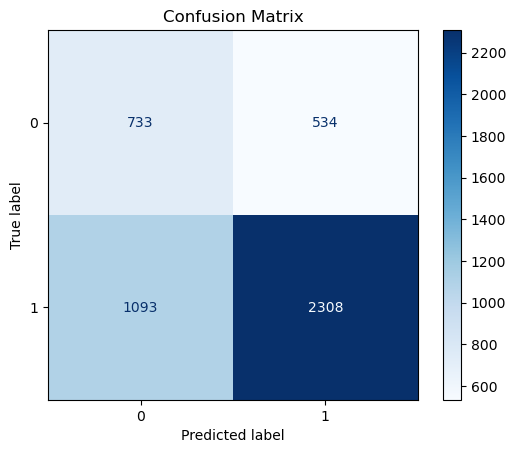

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_test_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("results/241118 EU/SVM_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()